In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())

!git clone https://github.com/SysCV/sam-hq.git
!pip install timm
os.chdir('sam-hq')
!export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamPredictor


PyTorch version: 2.1.0+cu118
CUDA is available: True
Cloning into 'sam-hq'...
remote: Enumerating objects: 431, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 431 (delta 98), reused 59 (delta 59), pack-reused 262
Receiving objects: 100% (431/431), 42.16 MiB | 32.29 MiB/s, done.
Resolving deltas: 100% (195/195), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00


/content/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/content/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_11m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/content/sam-hq/segment_anything/modeling/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_21m_224 in registry with segment_anything.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/content/sam-hq/se

In [2]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.9 MB/s eta 0:00:00


In [3]:
!mkdir pretrained_checkpoint
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
!mv sam_hq_vit_l.pth pretrained_checkpoint


--2023-11-27 06:26:43--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_l.pth
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.74, 3.163.189.37, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/e1a6c385d62bf005ded91a54d5ec55c985cfc4103ef89c08d90f39f04934c343?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_l.pth%3B+filename%3D%22sam_hq_vit_l.pth%22%3B&Expires=1701325603&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMTMyNTYwM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS80ZS9kOTRlMDQ5OTJhYzRlM2VhNDVmY2MxYzUyMzk3NDU0MGNkYmVmMjc0ZTI5NWQ0YWFhY2M2OWI0ZjE5ZWU2M2I3L2UxYTZjMzg1ZDYyYmYwMDVkZWQ5MWE1NGQ1ZWM1NWM5ODVjZmM0MTAzZWY4OWMwOGQ5MGYzOWYwNDkzNGMzNDM%7EcmVzcG9uc2

In [4]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


def show_res(masks, scores, input_point, input_label, input_box, image, image_out=None):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        if input_box is not None:
            box = input_box[i]
            show_box(box, plt.gca())
        if (input_point is not None) and (input_label is not None):
            show_points(input_point, input_label, plt.gca())

        print(f"Score: {score:.3f}")
        plt.axis('off')
        # Save the figure if image_out is provided
        if image_out is not None:
            # Ensure the directory exists
            plt.savefig(image_out, bbox_inches='tight')

        plt.show()


def show_res_multi(masks, scores, input_point, input_label, input_box, image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)
    for box in input_box:
        show_box(box, plt.gca())
    for score in scores:
        print(f"Score: {score:.3f}")
    plt.axis('off')
    plt.show()


In [10]:
import os


IMAGE_PATH1 = '/content/sam-hq/demo/input_imgs/Bag1.jpg'
IMAGE_PATH2 ='/content/sam-hq/demo/input_imgs/GasStation1.jpg'

In [11]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded



In [17]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH2)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [18]:
widget.bboxes

[{'x': 1172, 'y': 1766, 'width': 461, 'height': 772, 'label': ''}]

In [19]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])
print(box)

[1172 1766 1633 2538]


In [15]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_l.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

<All keys matched successfully>


In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Archway1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
print(masks.shape)

image[~masks.reshape(masks.shape[1:])]=255
output_file_fore = '/content/sam-hq/demo/input_imgs/Archway1foreground.jpg'
cv2.imwrite(output_file_fore, image)

(1, 3815, 5723)


True

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Archway1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Archway1background.jpg'
cv2.imwrite(output_file_back, image)

(3815, 5723, 3)


True

In [ ]:
image_archway2 = cv2.imread('/content/sam-hq/demo/input_imgs/Achway2.jpg')
image_archway2 = cv2.cvtColor(image_archway2, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image_archway2)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
print(masks.shape)

image_archway2[~masks.reshape(masks.shape[1:])]=255
output_file_fore = '/content/sam-hq/demo/input_imgs/Archway2foreground.jpg'
cv2.imwrite(output_file_fore, image_archway2)

(1, 1365, 1817)


True

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Achway2.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Archway2background.jpg'
cv2.imwrite(output_file_back, image)

(1365, 1817, 3)


True

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Airplane1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Airplane1background.jpg'
cv2.imwrite(output_file_back, image)

(1071, 1600, 3)


True

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Airplane1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[~masks.reshape(masks.shape[1:])] =255
output_file_fore = '/content/sam-hq/demo/input_imgs/Airplane1foreground.jpg'
cv2.imwrite(output_file_fore, image)

(1071, 1600, 3)


True

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Airplane2.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[~masks.reshape(masks.shape[1:])] =255
output_file_fore = '/content/sam-hq/demo/input_imgs/Airplane2foreground.jpg'
cv2.imwrite(output_file_fore, image)

(1491, 2572, 3)


True

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Airplane2.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Airplane2background.jpg'
cv2.imwrite(output_file_back, image)

(1491, 2572, 3)


True

In [16]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Bag1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
image = image.astype(np.uint16)
print(masks.shape)
image[masks[0],1] *= 2

image = np.minimum(image, 255).astype(np.uint8)
# masks = masks.reshape(masks.shape[1:])
# print(masks.shape)

# masks = masks.astype(np.uint8) * 255
# color_mask = cv2.cvtColor(masks, cv2.COLOR_GRAY2BGR)
# color_mask[:, :, 1] = 255  # Set the green channel to 255

# print(color_mask.shape, image.shape)
# result = cv2.addWeighted(image, 1, color_mask, 0.1, 0)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite('/content/sam-hq/demo/input_imgs/maskedBag1.jpg', image)



(1, 2592, 1944)


True

In [ ]:
#bag1-fore
image = cv2.imread('/content/sam-hq/demo/input_imgs/Bag1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[~masks.reshape(masks.shape[1:])] =255
output_file_fore = '/content/sam-hq/demo/input_imgs/Bag1foreground.jpg'
cv2.imwrite(output_file_fore, image)

(2592, 1944, 3)


True

In [ ]:
#bag1-back
image = cv2.imread('/content/sam-hq/demo/input_imgs/Bag1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Bag1background.jpg'
cv2.imwrite(output_file_back, image)

(2592, 1944, 3)


True

In [ ]:
#Bridge1

image = cv2.imread('/content/sam-hq/demo/input_imgs/Bridge1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[~masks.reshape(masks.shape[1:])] =255
output_file_fore = '/content/sam-hq/demo/input_imgs/Bridge1foreground.jpg'
cv2.imwrite(output_file_fore, image)


(3380, 5328, 3)


True

In [ ]:

image = cv2.imread('/content/sam-hq/demo/input_imgs/Bridge1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Bridge1background.jpg'
cv2.imwrite(output_file_back, image)

(3380, 5328, 3)


True

In [ ]:
#Clothes1

image = cv2.imread('/content/sam-hq/demo/input_imgs/Clothes1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[~masks.reshape(masks.shape[1:])] =255
output_file_fore = '/content/sam-hq/demo/input_imgs/Clothes1foreground.jpg'
cv2.imwrite(output_file_fore, image)


(533, 800, 3)


True

In [ ]:

image = cv2.imread('/content/sam-hq/demo/input_imgs/Clothes1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Clothes1background.jpg'
cv2.imwrite(output_file_back, image)

(533, 800, 3)


True

In [ ]:
#Fence1

image = cv2.imread('/content/sam-hq/demo/input_imgs/Fence1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[~masks.reshape(masks.shape[1:])] =255
output_file_fore = '/content/sam-hq/demo/input_imgs/Fence1foreground.jpg'
cv2.imwrite(output_file_fore, image)


(1098, 1600, 3)


True

(1098, 1600, 3)
Score: 0.610


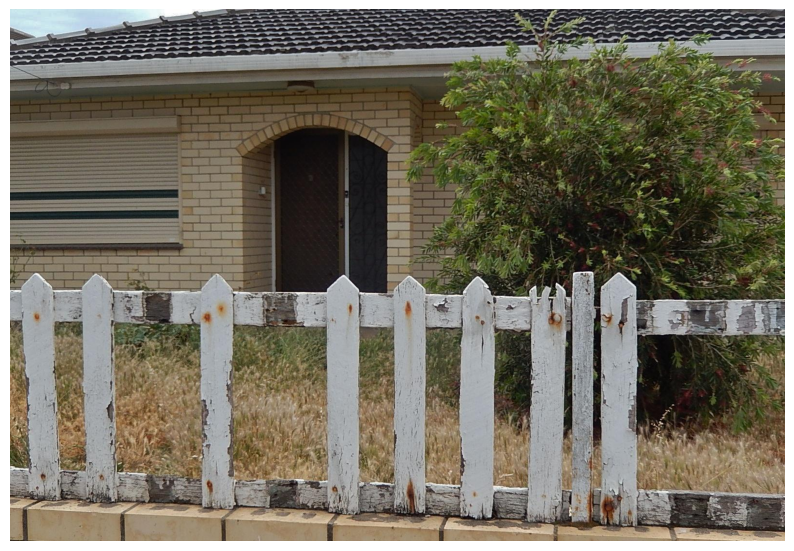

True

In [ ]:

image = cv2.imread('/content/sam-hq/demo/input_imgs/Fence1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
output_file_back = '/content/sam-hq/demo/input_imgs/Fence1background.jpg'
cv2.imwrite(output_file_back, image)

In [ ]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/Fence1background.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output_temp = '/content/sam-hq/demo/input_imgs/Fencetemp.jpg'
cv2.imwrite(output_file_fore, image)

True

In [ ]:
#GasStation1

image = cv2.imread('/content/sam-hq/demo/input_imgs/GasStation1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

print(masks.shape, masks.max())
image[~masks.reshape(masks.shape[1:])] =255
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_file_fore, image)


(1, 2920, 4032) True


True

In [ ]:

image = cv2.imread('/content/sam-hq/demo/input_imgs/GasStation1.jpg')
print(image.shape)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)

image[masks.reshape(masks.shape[1:])] =255
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
output_file_back = '/content/sam-hq/demo/input_imgs/GasStation1background.jpg'
cv2.imwrite(output_file_back, image)

(2920, 4032, 3)


True

In [20]:
image = cv2.imread('/content/sam-hq/demo/input_imgs/GasStation1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_box = np.array([box])
input_point, input_label = None, None
predictor.set_image(image)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box = input_box,
    multimask_output=False,
    hq_token_only= False,
)
image = image.astype(np.uint16)
print(masks.shape)
image[masks[0],1] *= 2

image = np.minimum(image, 255).astype(np.uint8)
# masks = masks.reshape(masks.shape[1:])
# print(masks.shape)

# masks = masks.astype(np.uint8) * 255
# color_mask = cv2.cvtColor(masks, cv2.COLOR_GRAY2BGR)
# color_mask[:, :, 1] = 255  # Set the green channel to 255

# print(color_mask.shape, image.shape)
# result = cv2.addWeighted(image, 1, color_mask, 0.1, 0)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite('/content/sam-hq/demo/input_imgs/maskedGasStation1.jpg', image)



(1, 2920, 4032)


True